In [1]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import *
import datetime
import datetime as dt

# import wrds
conn = wrds.Connection(wrds_username='angysharrington')

# Defining dates to load data
today = datetime.date.today()
current_quarter = (today.month - 1) // 3 + 1
current_year    = today.year
first_month_of_current_quarter = (current_quarter - 1) * 3 + 1
first_day_of_current_quarter = datetime.date(today.year, first_month_of_current_quarter, 1)
last_day_of_previous_quarter = first_day_of_current_quarter - datetime.timedelta(days=1)

## LOADING CRSP DATA FROM WRDS -- T-Bill data
rf = conn.raw_sql("""
                      select caldt, t30ret
                      from crsp.mcti
                      """)
rf['caldt']   = pd.DataFrame(rf[['caldt']].values.astype('datetime64[ns]')) + MonthEnd(0)
rf = rf.rename(columns={"caldt":"date","t30ret":"rf"}).copy()

# Load CRSP returns and change variables format
crsp_raw = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc, a.cfacshr, a.cfacpr
                      from crspq.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1900' and '"""+last_day_of_previous_quarter.strftime("%m/%d/%Y")+"""'
                      """)
crsp_raw = crsp_raw.sort_values(['permno','date']).reset_index(drop=True).copy()
crsp_raw[['permno', 'permco']] = crsp_raw[['permno', 'permco']].astype(int)
crsp_raw['date']   = pd.to_datetime(crsp_raw['date'],format='%Y-%m-%d',errors='ignore')+ MonthEnd(0)

# Load CRSP Deslisting returns and change variables format
dlret_raw = conn.raw_sql("""
                     select permno, dlret, dlstdt, dlstcd
                     from crspq.msedelist
                     """)
dlret_raw = dlret_raw.sort_values(['permno','dlstdt']).reset_index(drop=True).copy()
dlret_raw.permno    = dlret_raw.permno.astype(int)
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw['date']  = dlret_raw['dlstdt']+MonthEnd(0)
conn.close()

/Users/angusharrington/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading library list...
Done


/var/folders/md/nwtlzwyn0r9b_y_b8kt73c700000gn/T/ipykernel_51726/2819026135.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  crsp_raw['date']   = pd.to_datetime(crsp_raw['date'],format='%Y-%m-%d',errors='ignore')+ MonthEnd(0)


In [2]:
crsp  = pd.merge(crsp_raw, dlret_raw, how='left', on=['permno', 'date'])

crsp = crsp[(crsp['shrcd'] == 10) | (crsp['shrcd'] == 11)]
crsp = crsp[(crsp['exchcd'] == 1) | (crsp['exchcd'] == 2) | (crsp['exchcd'] == 3)]
crsp = crsp.copy()

# Compute returns including delisting returns
aux = crsp[(crsp['ret'].isna() & crsp['dlret'].isna())].index
crsp['dlret']   = crsp['dlret'].fillna(0)
crsp['ret']     = crsp['ret'].fillna(0)
crsp['ret']    = (1+crsp['ret']) * (1+crsp['dlret']) - 1
crsp.loc[aux,['ret']] = np.nan
crsp = crsp.drop(['dlstcd'], axis=1)

# Market Equity (Market Capitalization)
crsp['me']      = crsp['prc'].abs()*crsp['shrout']/ 1e3  # calculate market equity
crsp            = crsp.drop(['dlret', 'dlstdt', 'permco','retx', 'shrout', 'cfacshr','cfacpr', 'shrcd'], axis=1)

# Lagged Market Equity (to be used as weights)
crsp            = crsp.sort_values(by=['permno','date']).reset_index().drop('index',axis=1).copy()
crsp['daten']      = crsp['date'].dt.year*12 + crsp['date'].dt.month
crsp['IsValidLag'] = crsp['daten'].diff(1) == 1 # Lag date has to be the lagged date
crsp.loc[crsp[crsp['permno'].diff(1) != 0].index,['IsValidLag']] = False # Lagged date has to be the same security
crsp['Lme'] = crsp[['permno','me']].groupby('permno').shift(1)
crsp.loc[crsp[crsp['IsValidLag'] == False].index,['Lme']] = np.nan
crsp = crsp.drop(['IsValidLag','daten'], axis=1)

# Substituing missing returns with zero (no trade assumption)
crsp.loc[crsp['ret'].isna(),'ret'] = 0

# Dropping missing Lagged market cap data (zero weight in the market portfolio)
crsp = crsp.loc[crsp['Lme'] > 0,:].copy()

crsp = crsp.sort_values(by=['date','permno']).reset_index().drop('index',axis=1).copy()

# Sorting by date and permno
crsp

,permno,date,exchcd,ret,prc,me,Lme
0,10006,1926-01-31,1.0,0.032732,110.2500,66.15000,65.400000
1,10022,1926-01-31,1.0,0.017857,57.0000,11.40000,11.200000
2,10030,1926-01-31,1.0,0.161667,174.2500,27.18300,23.400000
3,10057,1926-01-31,1.0,-0.035714,-11.8125,5.90625,6.125000
4,10073,1926-01-31,1.0,0.050000,18.3750,2.53575,2.415000
...,...,...,...,...,...,...,...
3713869,93397,2023-12-31,3.0,0.362171,20.6300,371.21622,273.508800
3713870,93423,2023-12-31,1.0,0.007229,25.0800,2095.10796,2080.071300
3713871,93426,2023-12-31,1.0,0.117416,34.0700,426.21570,381.429900
3713872,93434,2023-12-31,3.0,0.065449,0.7000,30.30440,28.276623


In [281]:
CRSP_Stocks_Momentum = pd.DataFrame()
CRSP_Stocks_Momentum["Year"] = crsp["date"].dt.year
CRSP_Stocks_Momentum["Month"] = crsp["date"].dt.month
CRSP_Stocks_Momentum["permno"] = crsp["permno"]
CRSP_Stocks_Momentum["EXCHCD"] = crsp["exchcd"]
CRSP_Stocks_Momentum["lag_Mkt_Cap"] = crsp["Lme"]
CRSP_Stocks_Momentum["Ret"] = crsp["ret"]

In [282]:
CRSP_Stocks_Momentum

,Year,Month,permno,EXCHCD,lag_Mkt_Cap,Ret
0,1926,1,10006,1.0,65.400000,0.032732
1,1926,1,10022,1.0,11.200000,0.017857
2,1926,1,10030,1.0,23.400000,0.161667
3,1926,1,10057,1.0,6.125000,-0.035714
4,1926,1,10073,1.0,2.415000,0.050000
...,...,...,...,...,...,...
3713869,2023,12,93397,3.0,273.508800,0.362171
3713870,2023,12,93423,1.0,2080.071300,0.007229
3713871,2023,12,93426,1.0,381.429900,0.117416
3713872,2023,12,93434,3.0,28.276623,0.065449


In [283]:
CRSP_Stocks_Momentum['Weighted_RET'] = CRSP_Stocks_Momentum["lag_Mkt_Cap"]*CRSP_Stocks_Momentum["Ret"]
CRSP_Stocks_Momentum['Total_MV'] = CRSP_Stocks_Momentum.groupby(['Year', 'Month'])['lag_Mkt_Cap'].transform('sum')
CRSP_Stocks_Momentum['Stock_Vw_Ret'] = CRSP_Stocks_Momentum['Weighted_RET'] / CRSP_Stocks_Momentum['Total_MV']
Market_returns = CRSP_Stocks_Momentum.groupby(['Year', 'Month'])['Stock_Vw_Ret'].sum().reset_index()
Market_returns['Mkt'] = Market_returns['Stock_Vw_Ret']
Market_returns['MA'] = Market_returns['Mkt'].rolling(12).mean().shift(1)

Market_returns

,Year,Month,Stock_Vw_Ret,Mkt,MA
0,1926,1,0.000247,0.000247,NaN
1,1926,2,-0.033976,-0.033976,NaN
2,1926,3,-0.064875,-0.064875,NaN
3,1926,4,0.036735,0.036735,NaN
4,1926,5,0.011971,0.011971,NaN
...,...,...,...,...,...
1171,2023,8,-0.019338,-0.019338,0.011638
1172,2023,9,-0.048173,-0.048173,0.013014
1173,2023,10,-0.027157,-0.027157,0.016634
1174,2023,11,0.092792,0.092792,0.007652


In [284]:
CRSP_Stocks_Momentum['Year'] = CRSP_Stocks_Momentum['Year'].astype(int)
CRSP_Stocks_Momentum['Month'] = CRSP_Stocks_Momentum['Month'].astype(int)
Market_returns['Year'] = Market_returns['Year'].astype(int)
Market_returns['Month'] = Market_returns['Month'].astype(int)

CRSP_Stocks_Momentum = pd.merge(CRSP_Stocks_Momentum, Market_returns[['Year', 'Month', 'Mkt', 'MA']],on=['Year','Month'],how='inner')
CRSP_Stocks_Momentum

,Year,Month,permno,EXCHCD,lag_Mkt_Cap,Ret,Weighted_RET,Total_MV,Stock_Vw_Ret,Mkt,MA
0,1926,1,10006,1.0,65.400000,0.032732,2.140673,2.690395e+04,7.956722e-05,0.000247,NaN
1,1926,1,10022,1.0,11.200000,0.017857,0.199998,2.690395e+04,7.433792e-06,0.000247,NaN
2,1926,1,10030,1.0,23.400000,0.161667,3.783008,2.690395e+04,1.406116e-04,0.000247,NaN
3,1926,1,10057,1.0,6.125000,-0.035714,-0.218748,2.690395e+04,-8.130711e-06,0.000247,NaN
4,1926,1,10073,1.0,2.415000,0.050000,0.120750,2.690395e+04,4.488188e-06,0.000247,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3713869,2023,12,93397,3.0,273.508800,0.362171,99.056956,4.434792e+07,2.233633e-06,0.052970,0.011303
3713870,2023,12,93423,1.0,2080.071300,0.007229,15.036835,4.434792e+07,3.390652e-07,0.052970,0.011303
3713871,2023,12,93426,1.0,381.429900,0.117416,44.785973,4.434792e+07,1.009878e-06,0.052970,0.011303
3713872,2023,12,93434,3.0,28.276623,0.065449,1.850677,4.434792e+07,4.173086e-08,0.052970,0.011303


In [285]:
def normal_beta(stock_returns, market_returns, window=12):
    # Ensure the indexes of both series match
    stock_returns = stock_returns.copy()
    market_returns = market_returns.copy()

    # Calculate rolling covariance and variance
    rolling_cov = stock_returns.rolling(window=window).cov(market_returns)
    rolling_var = market_returns.rolling(window=window).var()

    # Calculate rolling beta
    rolling_beta = rolling_cov / rolling_var

    return rolling_beta

In [286]:
CRSP_Stocks_Momentum=CRSP_Stocks_Momentum.sort_values(['permno','Year','Month'])

window = 12  # Rolling window size in months

# Group by permno and apply rolling calculations
rolling_normal_beta = CRSP_Stocks_Momentum.groupby('permno')[['Ret', 'Mkt']].apply(lambda x:normal_beta(x['Ret'],x['Mkt']))

rolling_normal_beta

permno         
10000   1410160         NaN
        1415845         NaN
        1421512         NaN
        1427193         NaN
        1432889         NaN
                     ...   
93436   3697601    1.561835
        3701710    1.915407
        3705792    3.104368
        3709853    3.256498
        3713873    2.402869
Length: 3713874, dtype: float64

In [287]:
CRSP_Stocks_Momentum['rolling_normal_beta'] = rolling_normal_beta.reset_index(drop=True)
CRSP_Stocks_Momentum=CRSP_Stocks_Momentum.sort_values(['permno','Year','Month'])
CRSP_Stocks_Momentum['lag_rolling_beta'] = CRSP_Stocks_Momentum.groupby('permno')['rolling_normal_beta'].shift(1)
CRSP_Stocks_Momentum['timing']=np.where(CRSP_Stocks_Momentum['Mkt']<CRSP_Stocks_Momentum['MA'],1,0)
CRSP_Stocks_Momentum
downside_data = CRSP_Stocks_Momentum[CRSP_Stocks_Momentum['timing']==1]
downside_data

,Year,Month,permno,EXCHCD,lag_Mkt_Cap,Ret,Weighted_RET,Total_MV,Stock_Vw_Ret,Mkt,MA,rolling_normal_beta,lag_rolling_beta,timing
1421512,1986,4,10000,3.0,16.330000,-0.098592,-1.610007,2.361316e+06,-6.818263e-07,-0.007902,0.027889,0.131721,-0.611645,1
1432889,1986,6,10000,3.0,11.793878,-0.005025,-0.059264,2.448018e+06,-2.420907e-08,0.015576,0.026898,2.023746,0.976730,1
1438628,1986,7,10000,3.0,11.734594,-0.080808,-0.948249,2.493842e+06,-3.802363e-07,-0.059301,0.026670,0.036341,2.023746,1
1450273,1986,9,10000,3.0,4.148594,-0.057143,-0.237063,2.494548e+06,-9.503247e-08,-0.081517,0.027644,0.431770,0.539903,1
1462051,1986,11,10000,3.0,3.002344,0.060000,0.180141,2.394030e+06,7.524577e-08,0.015580,0.024516,1.010577,0.404982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3664048,2022,12,93436,3.0,614814.314400,-0.367334,-225842.201366,4.046104e+07,-5.581720e-03,-0.060761,-0.008870,1.624467,2.953251,1
3672571,2023,2,93436,3.0,548085.921660,0.187565,102801.735896,4.051539e+07,2.537350e-03,-0.022399,-0.005486,0.937258,0.937601,1
3697601,2023,8,93436,3.0,848821.183680,-0.034962,-29676.486224,4.524710e+07,-6.558760e-04,-0.019338,0.011638,0.403443,0.958990,1
3701710,2023,9,93436,3.0,819144.339780,-0.030456,-24947.860012,4.420206e+07,-5.644049e-04,-0.048173,0.013014,2.727804,0.403443,1


In [288]:
def get_beta(stock_returns, market_returns):
    if len(stock_returns) < 2 or len(market_returns) < 2:
        return np.nan
    if stock_returns.isna().any() or market_returns.isna().any():
        return np.nan
    covar = stock_returns.cov(market_returns)
    variance = market_returns.var()


    beta = covar / variance
    return beta

In [289]:
downside_beta = downside_data.groupby(['permno','Year'])[['Ret', 'Mkt']].apply(lambda x:get_beta(x['Ret'],x['Mkt']))
downside_beta.reset_index(drop=True)
downside_beta

permno  Year
10000   1986    1.009292
        1987   -8.109116
10001   1986    0.298387
        1987   -0.150918
        1988    0.401746
                  ...   
93436   2019    3.660723
        2020    3.634456
        2021   -0.038172
        2022    0.493899
        2023    2.167701
Length: 327566, dtype: float64

In [290]:
CRSP_Stocks_Momentum

,Year,Month,permno,EXCHCD,lag_Mkt_Cap,Ret,Weighted_RET,Total_MV,Stock_Vw_Ret,Mkt,MA,rolling_normal_beta,lag_rolling_beta,timing
1410160,1986,2,10000,3.0,16.100000,-0.257143,-4.140002,2.098832e+06,-1.972527e-06,0.076584,0.018256,-0.642409,NaN,0
1415845,1986,3,10000,3.0,11.960000,0.365385,4.370005,2.248689e+06,1.943357e-06,0.054762,0.023135,-0.611645,-0.642409,0
1421512,1986,4,10000,3.0,16.330000,-0.098592,-1.610007,2.361316e+06,-6.818263e-07,-0.007902,0.027889,0.131721,-0.611645,1
1427193,1986,5,10000,3.0,15.172000,-0.222656,-3.378137,2.338960e+06,-1.444290e-06,0.051116,0.027430,0.976730,0.131721,0
1432889,1986,6,10000,3.0,11.793878,-0.005025,-0.059264,2.448018e+06,-2.420907e-08,0.015576,0.026898,2.023746,0.976730,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697601,2023,8,93436,3.0,848821.183680,-0.034962,-29676.486224,4.524710e+07,-6.558760e-04,-0.019338,0.011638,0.403443,0.958990,1
3701710,2023,9,93436,3.0,819144.339780,-0.030456,-24947.860012,4.420206e+07,-5.644049e-04,-0.048173,0.013014,2.727804,0.403443,1
3705792,2023,10,93436,3.0,795449.380000,-0.197346,-156978.753345,4.195857e+07,-3.741280e-03,-0.027157,0.016634,0.505150,2.727804,1
3709853,2023,11,93436,3.0,638454.493640,0.195379,124740.600513,4.065520e+07,3.068257e-03,0.092792,0.007652,1.162949,0.505150,0


In [354]:
downside_beta.reset_index(drop=True)

betas_d = downside_beta.copy()
betas_d = betas_d.reset_index()
betas_d.columns = ['permno', 'Year', 'beta_d']
betas_d['Year'] = betas_d['Year'] + 1
print(betas_d)
df = pd.merge(CRSP_Stocks_Momentum, betas_d, on=['permno', 'Year'], how='left')
df['signal'] = df['lag_rolling_beta'] - df['beta_d']
def safe_qcut(series, q, labels):

    unique_vals = series.nunique()
    if unique_vals < q:
        bins = min(unique_vals, q)
        return pd.qcut(series, bins, labels=labels[:bins], duplicates='drop')
    else:
        return pd.qcut(series, q, labels=labels, duplicates='drop')


df['Decile'] = df.groupby(['Year'])['signal'].transform(
    lambda x: safe_qcut(x, 10, labels=np.arange(1, 11))
)

df

        permno  Year    beta_d
0        10000  1987  1.009292
1        10000  1988 -8.109116
2        10001  1987  0.298387
3        10001  1988 -0.150918
4        10001  1989  0.401746
...        ...   ...       ...
327561   93436  2020  3.660723
327562   93436  2021  3.634456
327563   93436  2022 -0.038172
327564   93436  2023  0.493899
327565   93436  2024  2.167701

[327566 rows x 3 columns]


,Year,Month,permno,EXCHCD,lag_Mkt_Cap,Ret,Weighted_RET,Total_MV,Stock_Vw_Ret,Mkt,MA,rolling_normal_beta,lag_rolling_beta,timing,beta_d,signal,Decile
0,1986,2,10000,3.0,16.100000,-0.257143,-4.140002,2.098832e+06,-1.972527e-06,0.076584,0.018256,-0.642409,NaN,0,NaN,NaN,NaN
1,1986,3,10000,3.0,11.960000,0.365385,4.370005,2.248689e+06,1.943357e-06,0.054762,0.023135,-0.611645,-0.642409,0,NaN,NaN,NaN
2,1986,4,10000,3.0,16.330000,-0.098592,-1.610007,2.361316e+06,-6.818263e-07,-0.007902,0.027889,0.131721,-0.611645,1,NaN,NaN,NaN
3,1986,5,10000,3.0,15.172000,-0.222656,-3.378137,2.338960e+06,-1.444290e-06,0.051116,0.027430,0.976730,0.131721,0,NaN,NaN,NaN
4,1986,6,10000,3.0,11.793878,-0.005025,-0.059264,2.448018e+06,-2.420907e-08,0.015576,0.026898,2.023746,0.976730,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713869,2023,8,93436,3.0,848821.183680,-0.034962,-29676.486224,4.524710e+07,-6.558760e-04,-0.019338,0.011638,0.403443,0.958990,1,0.493899,0.465091,7.0
3713870,2023,9,93436,3.0,819144.339780,-0.030456,-24947.860012,4.420206e+07,-5.644049e-04,-0.048173,0.013014,2.727804,0.403443,1,0.493899,-0.090456,6.0
3713871,2023,10,93436,3.0,795449.380000,-0.197346,-156978.753345,4.195857e+07,-3.741280e-03,-0.027157,0.016634,0.505150,2.727804,1,0.493899,2.233905,9.0
3713872,2023,11,93436,3.0,638454.493640,0.195379,124740.600513,4.065520e+07,3.068257e-03,0.092792,0.007652,1.162949,0.505150,0,0.493899,0.011251,6.0


In [355]:
portfolio_returns = df.groupby(['Year', 'Month', 'Decile']).apply(
    lambda df: pd.Series({
        'Sum_Weighted_Ret': df['Weighted_RET'].sum(),
        'Sum_Mkt_Cap': df['lag_Mkt_Cap'].sum()
    })
)

portfolio_returns['Value_Weighted_Ret'] = portfolio_returns['Sum_Weighted_Ret'] / portfolio_returns['Sum_Mkt_Cap']
portfolio_returns

/var/folders/md/nwtlzwyn0r9b_y_b8kt73c700000gn/T/ipykernel_51726/1180308494.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_returns = df.groupby(['Year', 'Month', 'Decile']).apply(


Sum_Weighted_Ret   Sum_Mkt_Cap  Value_Weighted_Ret
Year Month Decile                                                    
1928 1     1.0           -19.941723  2.351928e+03           -0.008479
           2.0           -14.867364  2.379500e+03           -0.006248
           3.0           -81.290592  6.140328e+03           -0.013239
           4.0            15.358697  5.689706e+03            0.002699
           5.0           -12.836001  4.838152e+03           -0.002653
...                             ...           ...                 ...
2023 12    6.0        237708.353172  9.664518e+06            0.024596
           7.0        172729.322242  4.048894e+06            0.042661
           8.0        285934.814596  5.057002e+06            0.056542
           9.0        192478.274008  3.074903e+06            0.062597
           10.0       170382.846431  3.435722e+06            0.049592

[11400 rows x 3 columns]

In [356]:
portfolio_returns.reset_index(inplace=True)

portfolio_returns = portfolio_returns[['Year', 'Month', 'Decile','Value_Weighted_Ret' ]]
portfolio_returns

,Year,Month,Decile,Value_Weighted_Ret
0,1928,1,1.0,-0.008479
1,1928,1,2.0,-0.006248
2,1928,1,3.0,-0.013239
3,1928,1,4.0,0.002699
4,1928,1,5.0,-0.002653
...,...,...,...,...
11395,2023,12,6.0,0.024596
11396,2023,12,7.0,0.042661
11397,2023,12,8.0,0.056542
11398,2023,12,9.0,0.062597


In [357]:
FF_mkt = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=3, nrows=1172)
FF_mkt.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

FF_mkt['Date'] = FF_mkt['Date'].astype(str)
FF_mkt['Year'] = FF_mkt['Date'].str[:4].astype(int)
FF_mkt['Month'] = FF_mkt['Date'].str[4:].astype(int)
FF_mkt.drop('Date', axis=1, inplace=True)
FF_mkt['RF'] = FF_mkt['RF'] / 100
FF_mkt['Mkt-RF'] = FF_mkt['Mkt-RF'] / 100
FF_mkt['SMB'] = FF_mkt['SMB'] / 100
FF_mkt['HML'] = FF_mkt['HML'] / 100

In [358]:
portfolio_returns = pd.merge(portfolio_returns, FF_mkt[['Year', 'Month', 'RF', 'SMB', 'HML']], on=['Year', 'Month'], how='inner')
portfolio_returns

,Year,Month,Decile,Value_Weighted_Ret,RF,SMB,HML
0,1928,1,1.0,-0.008479,0.0025,0.0426,-0.0075
1,1928,1,2.0,-0.006248,0.0025,0.0426,-0.0075
2,1928,1,3.0,-0.013239,0.0025,0.0426,-0.0075
3,1928,1,4.0,0.002699,0.0025,0.0426,-0.0075
4,1928,1,5.0,-0.002653,0.0025,0.0426,-0.0075
...,...,...,...,...,...,...,...
11395,2023,12,6.0,0.024596,0.0043,0.0634,0.0493
11396,2023,12,7.0,0.042661,0.0043,0.0634,0.0493
11397,2023,12,8.0,0.056542,0.0043,0.0634,0.0493
11398,2023,12,9.0,0.062597,0.0043,0.0634,0.0493


In [359]:
portfolio_returns["Excess_Ret"] = portfolio_returns["Value_Weighted_Ret"] - portfolio_returns["RF"]

In [360]:
time_filtered_data = portfolio_returns[(portfolio_returns['Year'] > 2000)]

grouped = time_filtered_data.groupby('Decile')

metrics = grouped.apply(lambda df: pd.Series({
    'Excess Return': round(df['Excess_Ret'].mean() * 1200, 2),
    'Volatility': round(df['Excess_Ret'].std() * np.sqrt(12) * 100, 2),
    'Sharpe Ratio': round((df['Excess_Ret'].mean() / df['Excess_Ret'].std()) * np.sqrt(12), 2),
    'Skewness': round(df['Excess_Ret'].skew(), 2)
}), include_groups=False)

time_filtered_data['Date'] = pd.to_datetime(time_filtered_data[['Year', 'Month']].assign(Day=1))
time_filtered_data.set_index('Date', inplace=True)

decile10_returns = time_filtered_data[time_filtered_data['Decile'] == 10]['Excess_Ret']
decile1_returns = time_filtered_data[time_filtered_data['Decile'] == 1]['Excess_Ret']

diff_returns = decile10_returns - decile1_returns

diff_metrics = {
    'Excess Return': round(diff_returns.mean()*1200, 2),
    'Volatility': round(diff_returns.std() * np.sqrt(12)*100, 2),
    'Sharpe Ratio': round(diff_returns.mean() / diff_returns.std() * np.sqrt(12), 2),
    'Skewness': round(diff_returns.skew(), 2)
}

metrics.loc['Decile 10-1'] = diff_metrics
metrics.T

/var/folders/md/nwtlzwyn0r9b_y_b8kt73c700000gn/T/ipykernel_51726/1846033378.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_data['Date'] = pd.to_datetime(time_filtered_data[['Year', 'Month']].assign(Day=1))


Decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,Decile 10-1
Excess Return,5.86,7.24,7.62,7.21,7.74,8.17,6.98,7.28,7.93,7.35,1.49
Volatility,26.80,22.94,19.16,16.45,16.39,15.40,15.50,16.06,16.11,16.75,18.39
Sharpe Ratio,0.22,0.32,0.40,0.44,0.47,0.53,0.45,0.45,0.49,0.44,0.08
Skewness,-0.60,-0.45,-0.32,-0.56,-0.65,-0.57,-0.46,-0.27,-0.41,-0.45,0.56


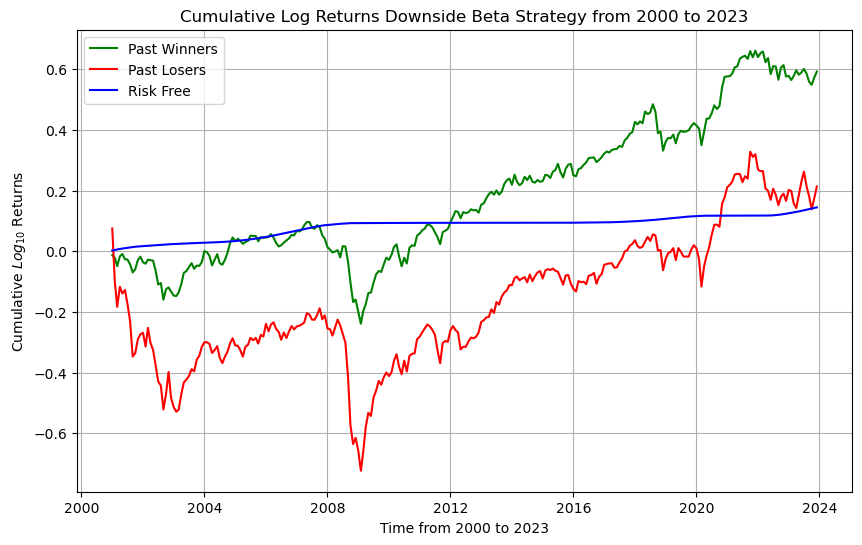

In [361]:
log_wml_returns = np.log10(1 + diff_returns)
log_dec10_returns = np.log10(1 + time_filtered_data[time_filtered_data['Decile'] == 10]['Excess_Ret'])
log_dec1_returns = np.log10(1 + time_filtered_data[time_filtered_data['Decile'] == 1]['Excess_Ret'])
log_risk_free = np.log10(1 + time_filtered_data[time_filtered_data['Decile'] == 1]['RF'])

cumulative_log_wml_returns = log_wml_returns.cumsum()
cumulative_dec10_returns = log_dec10_returns.cumsum()
cumulative_dec1_returns = log_dec1_returns.cumsum()
cumulative_rf_returns = log_risk_free.cumsum()


plt.figure(figsize=(10, 6))
#plt.plot(cumulative_log_wml_returns.index, cumulative_log_wml_returns, label='Cumulative Log Returns')
plt.plot(cumulative_dec10_returns.index, cumulative_dec10_returns, label='Past Winners', color="green")
plt.plot(cumulative_dec1_returns.index, cumulative_dec1_returns, label='Past Losers', color="red")
plt.plot(cumulative_rf_returns.index, cumulative_rf_returns, label='Risk Free', color="blue")

plt.xlabel('Time from 2000 to 2023')
plt.ylabel('Cumulative $Log_{10}$ Returns')
plt.title('Cumulative Log Returns Downside Beta Strategy from 2000 to 2023')
plt.legend()
plt.grid(True)
plt.show()